## Plotting Data

In [1]:
# Import all necessary libraries at the top
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import os
from tqdm import trange

Read Traces from bin file

In [ ]:
# ==============================================================================
#  CONFIGURATION
# ==============================================================================
# All user-configurable parameters are placed in this first cell for easy access.
folder = '/home/navarro/Desktop/hwsec_verilator/traces'
fixed_folder  = folder + '/fixed/'
random_folder = folder + '/random/'
output_folder = folder + '/tvla/'

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

N_TRACES = 100

# ==============================================================================
#  DATA LOADING
# ==============================================================================
print("--- Loading Trace Data ---")

# --- Determine Trace Size ---
try:
    trace_zero_path = f"{fixed_folder}trace_0.bin"
    size_array = np.fromfile(trace_zero_path, dtype=np.int32)
    num_samples = size_array.shape[0]
    print(f"Detected {num_samples} samples per trace.")
except FileNotFoundError:
    print(f"Error: Could not find initial trace file at {trace_zero_path}")
    # In a notebook, we might not want to exit, so we can raise an error
    raise

# --- Pre-allocate Memory and Load Traces ---
fixed_data  = np.zeros([num_samples, N_TRACES], dtype=np.int32)
random_data = np.zeros([num_samples, N_TRACES], dtype=np.int32)

# The tqdm.notebook wrapper will create a clean, interactive progress bar
for i in range(0, N_TRACES):
    fixed_data[:, i] = np.fromfile(f"{fixed_folder}trace_{i}.bin", dtype=np.int32)
    random_data[:, i] = np.fromfile(f"{random_folder}trace_{i}.bin", dtype=np.int32)

print(f"Successfully loaded {N_TRACES} fixed and {N_TRACES} random traces.")

--- Loading Trace Data ---
Detected 2000 samples per trace.
Successfully loaded 100 fixed and 100 random traces.


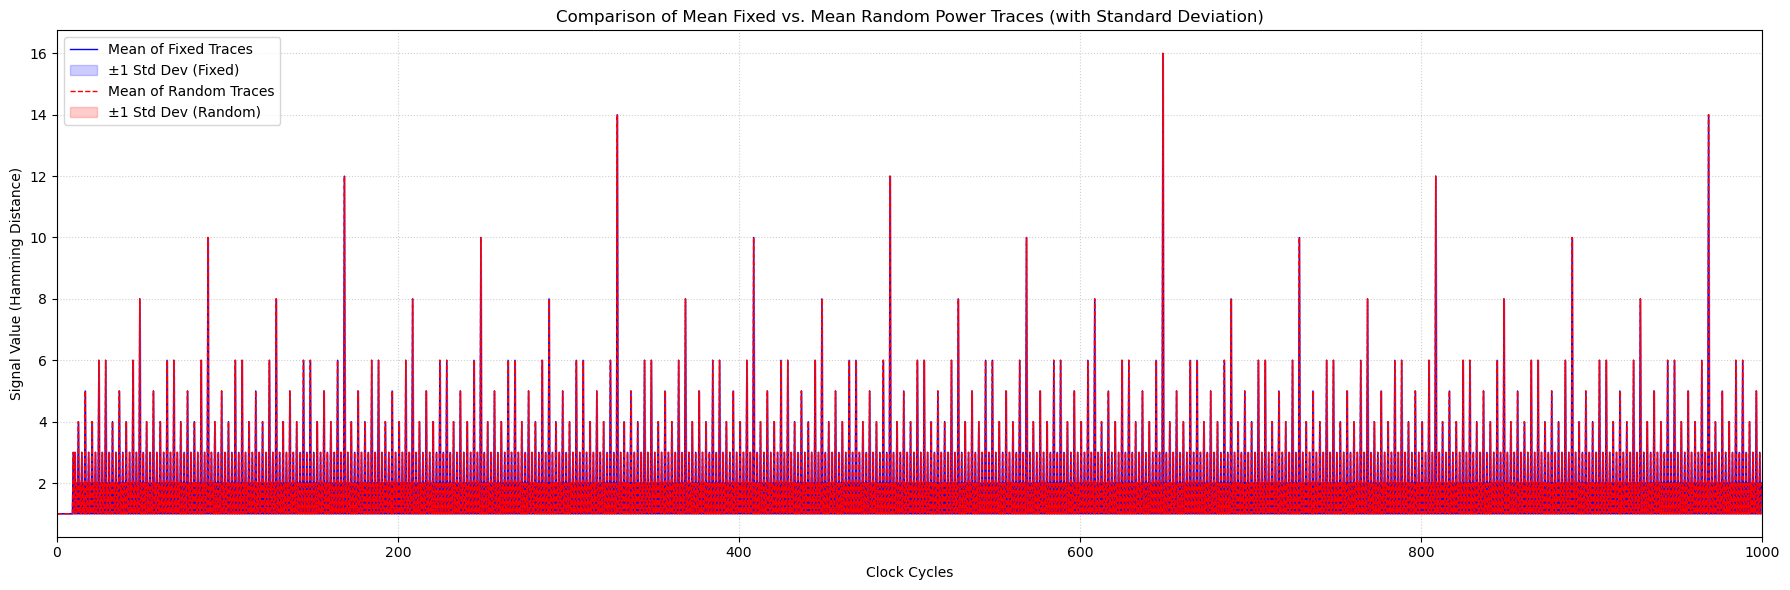

In [5]:
# ==============================================================================
#  PLOT MEAN TRACES
# ==============================================================================
# --- 1. Get the number of samples ---
num_samples = fixed_data.shape[0]

# --- 2. Calculate Mean and Standard Deviation for each dataset ---
mean_fixed_trace = np.mean(fixed_data, axis=1)
std_fixed_trace = np.std(fixed_data, axis=1)

mean_random_trace = np.mean(random_data, axis=1)
std_random_trace = np.std(random_data, axis=1)

# --- 3. Plotting ---
x_axis_values = np.arange(num_samples) / 2 # X-axis for clock cycles

fig, ax = plt.subplots(figsize=(18, 6))

# Plot the mean of the fixed traces
ax.plot(x_axis_values, mean_fixed_trace, label='Mean of Fixed Traces', color='blue', linewidth=1.0)
# Add a shaded region for the standard deviation
ax.fill_between(x_axis_values, 
                mean_fixed_trace - std_fixed_trace, 
                mean_fixed_trace + std_fixed_trace, 
                color='blue', alpha=0.2, label='±1 Std Dev (Fixed)')

# Plot the mean of the random traces
ax.plot(x_axis_values, mean_random_trace, label='Mean of Random Traces', color='red', linestyle='--', linewidth=1.0)
# Add a shaded region for the standard deviation
ax.fill_between(x_axis_values, 
                mean_random_trace - std_random_trace, 
                mean_random_trace + std_random_trace, 
                color='red', alpha=0.2, label='±1 Std Dev (Random)')


# --- 4. Customize Axes ---
# ax.set_ylim(0, 5200)
ax.set_xlim(0, num_samples / 2)

# --- 5. Add Labels, Title, and Legend ---
ax.set_xlabel('Clock Cycles')
ax.set_ylabel('Signal Value (Hamming Distance)')
ax.set_title('Comparison of Mean Fixed vs. Mean Random Power Traces (with Standard Deviation)')
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

First Order T-test

In [8]:
# ==============================================================================
#  HELPER FUNCTION FOR PLOTTING
# ==============================================================================

def plot_ttest(t_scores, title, output_filename, xlim_start=0, xlim_end=num_samples / 2):
    """
    Creates, shows, and saves a standardized plot for a t-test result.
    """
    print(f"\n--- Plotting: {title} ---")
    
    x_axis_values = np.arange(num_samples) / 2
    CRITICAL_VALUE = 4.5

    fig, ax = plt.subplots(figsize=(18, 6))
    
    ax.plot(x_axis_values, t_scores, color='blue', linewidth=0.7, label='t-statistic')
    
    y_lim_p = (ax.get_ylim()[1] if (ax.get_ylim()[1] >  4.5) else  4.5)
    y_lim_n = (ax.get_ylim()[0] if (ax.get_ylim()[0] < -4.5) else -4.5)

    ax.fill_between(x_axis_values, CRITICAL_VALUE, y_lim_p, color='red', alpha=0.1, label=f'Fail Zone (|t| > {CRITICAL_VALUE})')
    ax.fill_between(x_axis_values, -CRITICAL_VALUE, y_lim_n, color='red', alpha=0.1)
    ax.axhline(y=CRITICAL_VALUE, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=-CRITICAL_VALUE, color='red', linestyle='--', linewidth=1)

    ax.set_xlim(xlim_start, xlim_end)
    ax.set_xlabel('Clock Cycles')
    ax.set_ylabel('t-statistic')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    # plt.savefig(output_filename, format="pdf", bbox_inches="tight")
    plt.show() # This will render the plot directly below this cell
    
    print(f"  Max absolute t-score: {np.max(np.abs(t_scores)):.4f}")


--- Performing First Order TVLA ---

--- Plotting: First Order TVLA ---


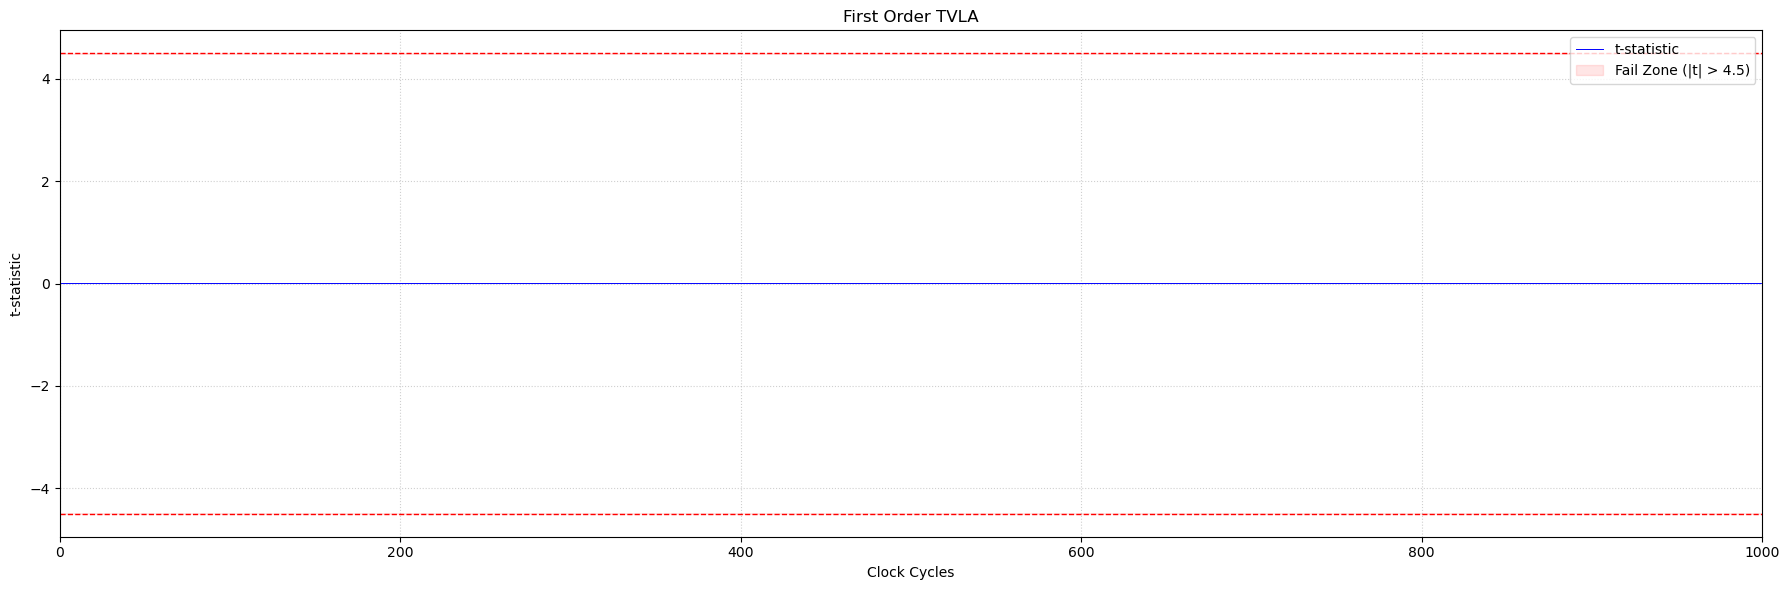

  Max absolute t-score: 0.0000


In [11]:
# ==============================================================================
#  FIRST ORDER TVLA (Test Vector Leakage Assessment)
# ==============================================================================
print("\n--- Performing First Order TVLA ---")

# --- Calculate t-test ---
t_test_1, _ = ss.ttest_ind(fixed_data, random_data, axis=1, equal_var=False)

# --- Sanitize Data (replace NaN/inf with 0) ---
t_scores_1 = np.nan_to_num(t_test_1, nan=0.0, posinf=0.0, neginf=0.0)

# --- Save and Plot Results ---
# t_scores_1.astype(np.float64).tofile(f"{output_folder}t_test_1.bin")
plot_ttest(t_scores_1, 'First Order TVLA', f"{output_folder}t_test_1.pdf", xlim_start=0, xlim_end=num_samples / 2)

Higher Order T-tests


--- Performing Higher Order TVLA ---

--- Plotting: Second Order TVLA (Centered Moment) ---


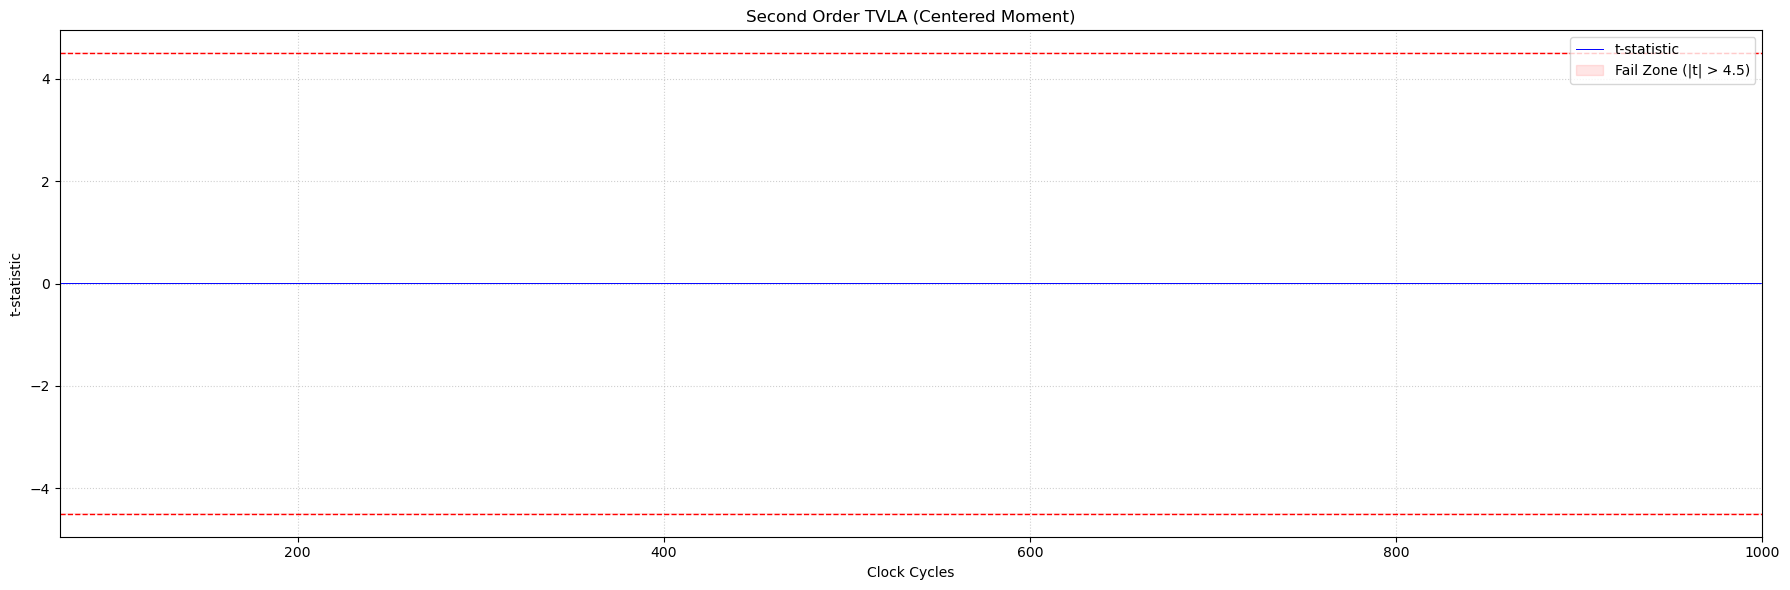

  Max absolute t-score: 0.0000

--- Plotting: Third Order TVLA (Centered Moment) ---


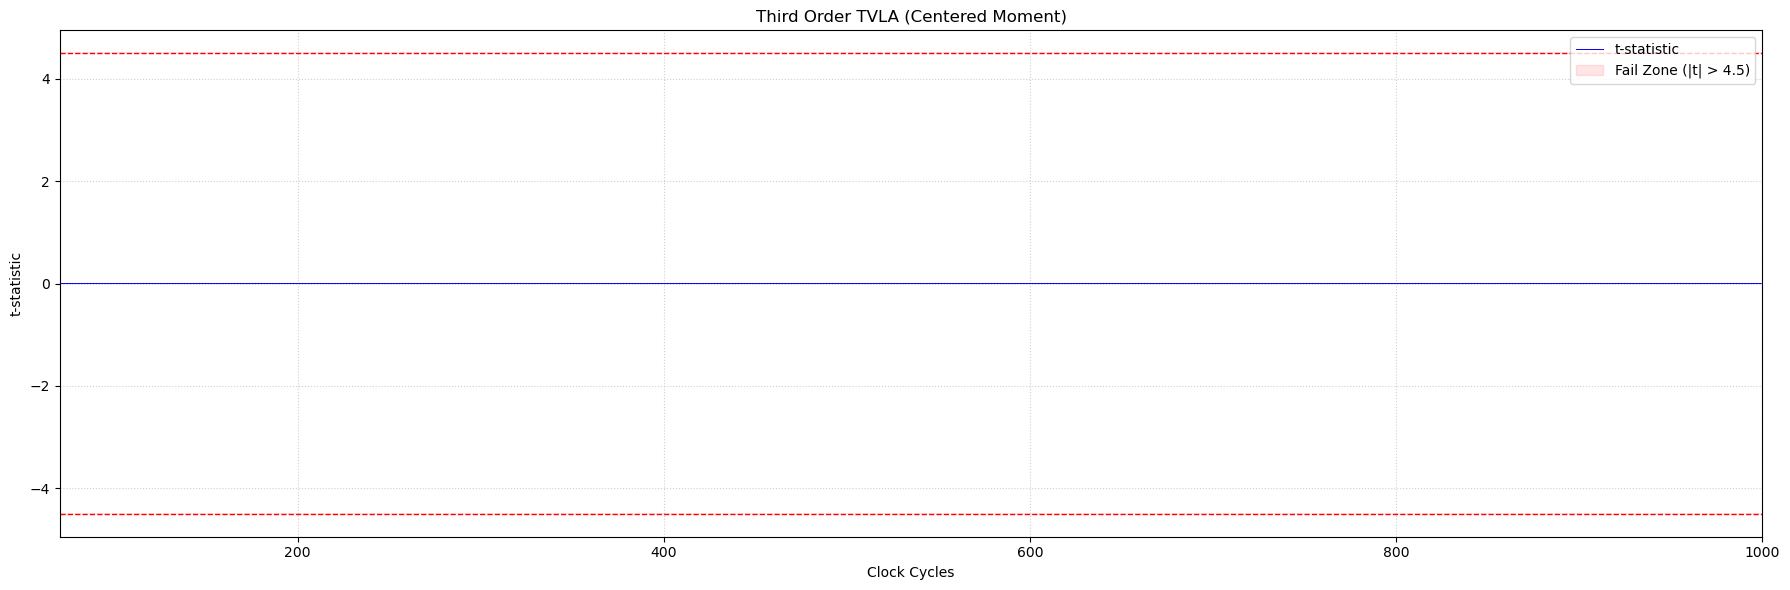

  Max absolute t-score: 0.0000


In [10]:
# ==============================================================================
#  SECOND & THIRD ORDER TVLA
# ==============================================================================
print("\n--- Performing Higher Order TVLA ---")

# --- Center the Traces (prepare for higher-order tests) ---
# This is done by subtracting the mean of each trace from that trace.
mean_fixed = np.mean(fixed_data, axis=0)
centered_fixed_data = fixed_data - mean_fixed

mean_random = np.mean(random_data, axis=0)
centered_random_data = random_data - mean_random

# --- Calculate 2nd Order TVLA (on the squared centered traces) ---
t_test_2, _ = ss.ttest_ind(
    np.power(centered_fixed_data, 2), 
    np.power(centered_random_data, 2), 
    axis=1, 
    equal_var=False
)
t_scores_2 = np.nan_to_num(t_test_2, nan=0.0, posinf=0.0, neginf=0.0)
# t_scores_2.astype(np.float64).tofile(f"{output_folder}t_test_2.bin")
plot_ttest(t_scores_2, 'Second Order TVLA (Centered Moment)', f"{output_folder}t_test_2.pdf", xlim_start=70)

# --- Calculate 3rd Order TVLA (on the cubed centered traces) ---
t_test_3, _ = ss.ttest_ind(
    np.power(centered_fixed_data, 3), 
    np.power(centered_random_data, 3), 
    axis=1, 
    equal_var=False
)
t_scores_3 = np.nan_to_num(t_test_3, nan=0.0, posinf=0.0, neginf=0.0)
# t_scores_3.astype(np.float64).tofile(f"{output_folder}t_test_3.bin")
plot_ttest(t_scores_3, 'Third Order TVLA (Centered Moment)', f"{output_folder}t_test_3.pdf", xlim_start=70)